<a href="https://colab.research.google.com/github/aleCastanheira/TCC_MBA/blob/main/02_statistical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

O setup basicamente consiste nos imports, na definição de constantes e na leitura do arquivo de metadados.

In [21]:
!pip install python-bcb
!pip install statsforecast

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md

from statsmodels.tsa.seasonal import STL
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

from bcb import sgs
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

import warnings
warnings.filterwarnings("ignore")

In [23]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [24]:
# CONSTANTES DO SCRIPT
FILEPATH = "/content/drive/MyDrive/TCC"
PROCESSED_METADATA_FILE = "processed_metadata.csv"
PROCESSED_METADATA_OUTLIERS_FILE = "processed_metadata_outliers.csv"
PROCESSED_METADATA_FILEPATH = f"{FILEPATH}/{PROCESSED_METADATA_FILE}"
PROCESSED_METADATA_OUTLIERS_FILEPATH = f"{FILEPATH}/{PROCESSED_METADATA_OUTLIERS_FILE}"

REF_DATE_KEY = "reference_date"
TOTAL_SIZE = "total_size"
TABLE_KEY = "table"

DATE_COLUMN = "ds"
VALUES_COLUMN = "y"
ARIMA_UNIQUE_ID = "unique_id"

# tabelas usadas para teste
tab_list = [
    'TAB000001', # crescimento constante, sem outliers aparente
    'TAB000005', # mantém um padrão constante, não deve ter outliers
    'TAB000008', # um pico grande no ano um
]

# outliers inseridos manualmente
added_noise_multiplier = {
    "TAB000005": [("2022-01-02", 0), ("2022-04-01", 0), ("2022-08-01", 0)],
    "TAB000008": [("2022-12-10", 0)],
}

# Range de datas usadas para os rótulos dos gráficos no eixo X
def get_date_strings(start_interval, end_interval):
    timestamps = pd.date_range(start=start_interval, end=end_interval, periods=6, inclusive='both')
    date_strings = [ts.strftime('%Y-%m-%d') for ts in timestamps]
    return date_strings

interval_list = [
    (
        "2021-01-01",
        "2021-06-30",
        get_date_strings("2021-01-01", "2021-06-30")
    ), #6 meses
    (
        "2021-01-01",
        "2021-12-31",
        get_date_strings("2021-01-01", "2021-12-31")
    ), #1 ano
    (
        "2021-01-01",
        "2022-12-31",
        get_date_strings("2021-01-01", "2022-12-31")
    ), #2 anos
]

metadata_files = [
    PROCESSED_METADATA_FILEPATH,
    PROCESSED_METADATA_OUTLIERS_FILEPATH
]

test_list = [
    #0:
    {"table_for_test": tab_list[0], "interval_for_test": interval_list[0], "filepath_for_test": metadata_files[1]},
    #2:
    {"table_for_test": tab_list[0], "interval_for_test": interval_list[2], "filepath_for_test": metadata_files[1]},
    #3:
    {"table_for_test": tab_list[1], "interval_for_test": interval_list[1], "filepath_for_test": metadata_files[1]},
    #4:
    {"table_for_test": tab_list[1], "interval_for_test": interval_list[2], "filepath_for_test": metadata_files[1]},
    #5:
    {"table_for_test": tab_list[2], "interval_for_test": interval_list[1], "filepath_for_test": metadata_files[1]},
    #6:
    {"table_for_test": tab_list[2], "interval_for_test": interval_list[2], "filepath_for_test": metadata_files[1]},
]

# Aqui é aonde customizo as execuções, para avaliar diferentes períodos temporais
test_choosen = 0

In [25]:
outliers_found = []

def add_outliers_found(method, total_outliers, percentage):
    global outliers_found
    item = {
        "method": method,
        "total_outliers": total_outliers,
        "percentage": "{:.2f}%".format(percentage)
    }
    outliers_found.append(item)

In [26]:
# Parâmetros escolhidos para o teste:
print( \
    f"""
    table = {test_list[test_choosen]["table_for_test"]}
    interval = {test_list[test_choosen]["interval_for_test"]}
    """
)


    table = TAB000001
    interval = ('2021-01-01', '2021-06-30', ['2021-01-01', '2021-02-06', '2021-03-14', '2021-04-19', '2021-05-25', '2021-06-30'])
    


In [27]:
# Função para fazer a plotagem do gráfico
def plot_graph(df, outliers_df=None, method=None, date_strings=[]):
    # plt.figure(figsize = (20,7))
    plt.clf()
    plt.locator_params(axis="x", nbins=6)

    plt.plot(df[DATE_COLUMN], df[VALUES_COLUMN], label='Série temporal')

    if outliers_df is not None:
        plt.scatter(
            outliers_df[DATE_COLUMN],
            outliers_df[VALUES_COLUMN],
            color='red',
            label='Anomalias detectadas'
        )

    # plt.xlabel("Data da ingestão (dia)")
    plt.ylabel("Tamanho dos arquivos (KBs)")
    plt.xticks(date_strings, rotation=10)

    plt.grid(True)
    # plt.show()
    if method:
        plt.title(f"Anomalias encontradas usando o método '{method}'", fontsize=10)
    else:
        plt.title("Dados presentes em uma tabela de Data Lake", fontsize=14)

    if outliers_df is not None:
        total_outliers = len(outliers_df)
        outlier_percent = (total_outliers / len(df)) * 100
        add_outliers_found(method, total_outliers, outlier_percent)
        img_name = f"{FILEPATH}/imgs/TEST{test_choosen+1}/{method}.png".replace(" ", "_")
        plt.savefig(img_name)

    plt.show()

## Statistical Methods: Z-Score



In [28]:
def process_zscore(data, date_strings):
    df = data.copy()

    method = "Z-score"
    df['Z-Score'] = np.abs((df[VALUES_COLUMN] - df[VALUES_COLUMN].mean()) / df[VALUES_COLUMN].std())
    outliers_z_score = df[df['Z-Score'] > 2]

    plot_graph(df, outliers_z_score, method, date_strings)

## Statistical Methods: IQR

In [29]:
def process_iqr(data, date_strings):
    df = data.copy()

    method = "IQR"

    Q1 = df[VALUES_COLUMN].quantile(0.25)
    Q3 = df[VALUES_COLUMN].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_iqr = df[(df[VALUES_COLUMN] < lower_bound) | (df[VALUES_COLUMN] > upper_bound)]
    iqr_outlier_percent = (len(outliers_iqr) / df.shape[0]) * 100

    plot_graph(df, outliers_iqr, method, date_strings)

## Local Outlier Factor

In [30]:
def process_lof(data, date_strings):
    df = data.copy()

    method = "LOF"

    lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')
    df['outlier'] = lof.fit_predict(df[[VALUES_COLUMN]])
    outliers_lof = df[df['outlier'] == -1]

    plot_graph(df, outliers_lof, method, date_strings)

## Isolation Forests

In [31]:
def process_isolation_forest(data, date_strings):
    df = data.copy()

    method = "Isolation Forest"

    isolation_forest = IsolationForest(contamination='auto')
    df['outlier'] = isolation_forest.fit_predict(df[[VALUES_COLUMN]])
    df['outlier'] = df['outlier'] == -1
    outliers_iso_forest = df[df['outlier']]
    iso_forest_outlier_percent = (len(outliers_iso_forest) / df.shape[0]) * 100

    plot_graph(df, outliers_iso_forest, method, date_strings)

## Series Decomposition

In [32]:
def process_series_decomposition(data, date_strings):
    df = data.copy()

    method = "Series Decomposition"

    autocorr = [df[VALUES_COLUMN].autocorr(lag) for lag in range(1,101)] # check up to a lag of 100
    period = np.argmax(autocorr) + 2  # add 1 to adjust for zero-based indexing
    stl = STL(df[VALUES_COLUMN], period=period)
    result = stl.fit()
    df['residual'] = result.resid
    df['Z-Score'] = np.abs((df['residual'] - df['residual'].mean()) / df['residual'].std())
    outliers_stl = df[df['Z-Score'] > 2]

    plot_graph(df, outliers_stl, method, date_strings)

## ARIMA



In [33]:
def process_arima(data, date_strings=None):
    df = data.copy()
    method = "ARIMA"

    # Criação do modelo Auto ARIMA
    models = [AutoARIMA(season_length = 12, approximation = True)]
    fcst = StatsForecast(df = df,
                        models = models,
                        freq = 'D',
                        n_jobs = -1)

    # Nível de confiança do ajuste
    levels = [95]

    # Previsão dentro da amostra
    forecasts = fcst.forecast(h = 48, fitted = True, level = levels)

    # Cria o ajuste
    insample_forecasts = fcst.forecast_fitted_values().reset_index()

    plt.plot(insample_forecasts['ds'], insample_forecasts['y'], linewidth = 2)
    outliers_df = insample_forecasts.query('y > `AutoARIMA-hi-95` or y < `AutoARIMA-lo-95`')[['ds', 'y']]

    plt.scatter(
        outliers_df[DATE_COLUMN],
        outliers_df[VALUES_COLUMN],
        color='red',
        label='Anomalias detectadas'
    )

    plt.grid()

    plt.ylabel("Tamanho dos arquivos (KBs)")
    plt.xticks(date_strings, rotation=10)

    table = test_list[test_choosen]["table_for_test"]
    plt.title(f"Anomalias encontradas usando o método '{method}'", fontsize=10)

    if outliers_df is not None:
        total_outliers = len(outliers_df)
        outlier_percent = (total_outliers / len(df)) * 100
        add_outliers_found(method, total_outliers, outlier_percent)
        img_name = f"{FILEPATH}/imgs/TEST{test_choosen+1}/{method}.png".replace(" ", "_")
        plt.savefig(img_name)

    plt.show()

##Tests

In [34]:
process_list = [
    # process_zscore,
    # process_iqr,
    process_lof,
    process_isolation_forest,
    process_series_decomposition,
    process_arima,
]


def run_test(test_choosen):
    START_DATE_INTERVAL = test_list[test_choosen]["interval_for_test"][0]
    END_DATE_INTERVAL = test_list[test_choosen]["interval_for_test"][1]

    # Range de datas usadas para os rótulos dos gráficos no eixo X
    date_strings = test_list[test_choosen]["interval_for_test"][2]

    original_data = (pd.read_csv(test_list[test_choosen]["filepath_for_test"], parse_dates=False)
        .rename(columns = {REF_DATE_KEY: DATE_COLUMN, TOTAL_SIZE: VALUES_COLUMN, TABLE_KEY: ARIMA_UNIQUE_ID})
    )

    data = original_data.copy()
    del data[data.columns[0]]

    # Filtrando para trazer apenas uma tabela
    data = data[data[ARIMA_UNIQUE_ID] == test_list[test_choosen]["table_for_test"]].copy()
    data = data[(data[DATE_COLUMN] >= START_DATE_INTERVAL) & (data[DATE_COLUMN] <= END_DATE_INTERVAL)]
    data[DATE_COLUMN].min(), data[DATE_COLUMN].max()

    data.describe()
    df = data.copy()

    # Cria o gráfico
    plot_graph(df, date_strings=date_strings)

    for process in process_list:
        process(data, date_strings)

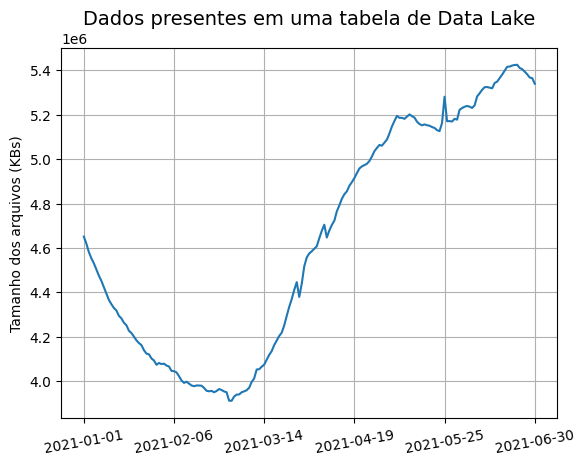

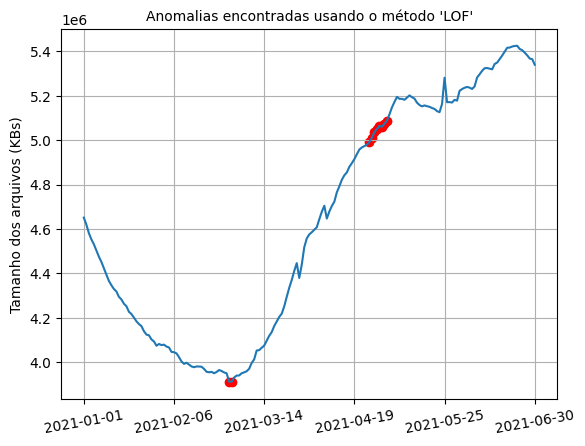

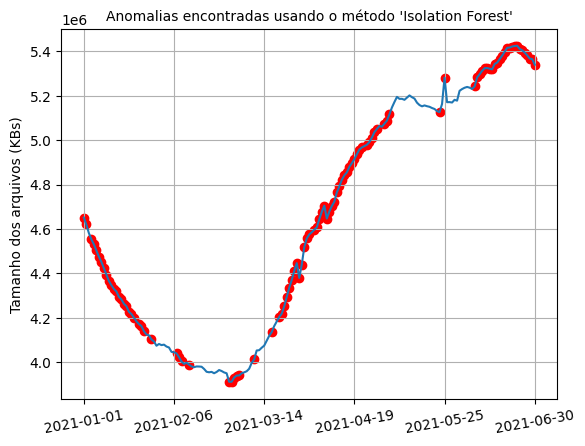

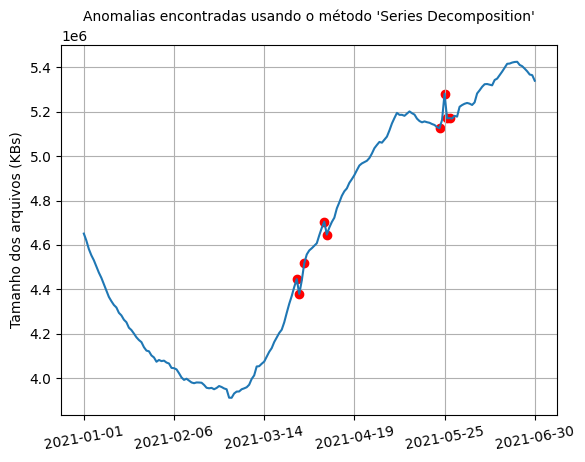

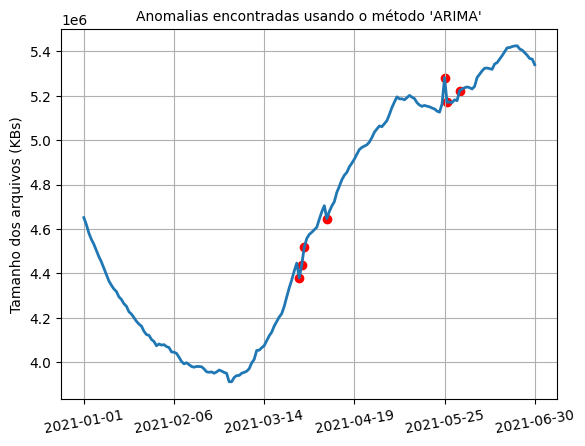

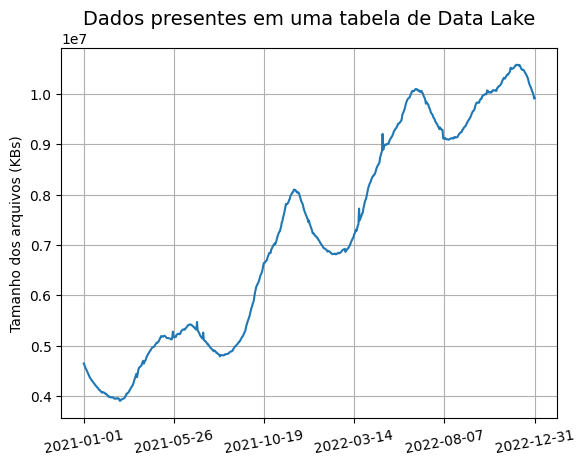

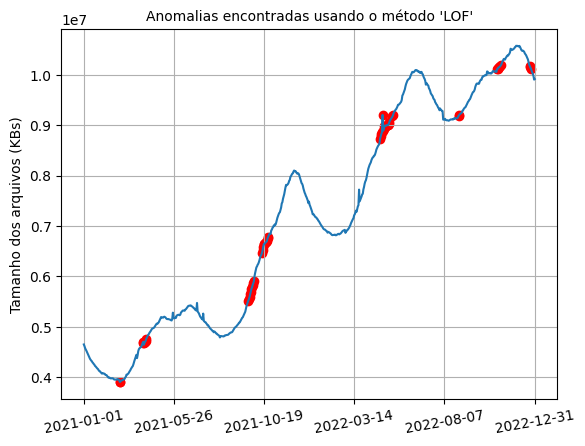

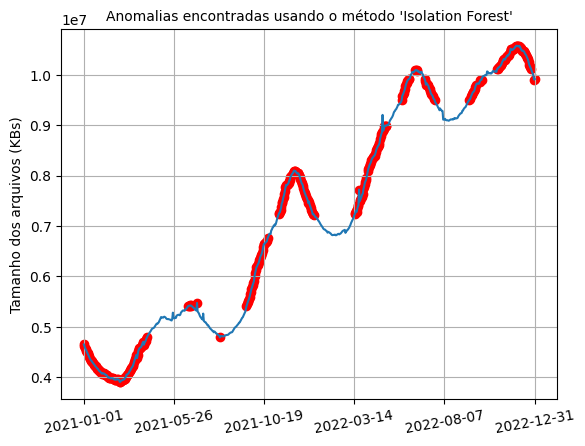

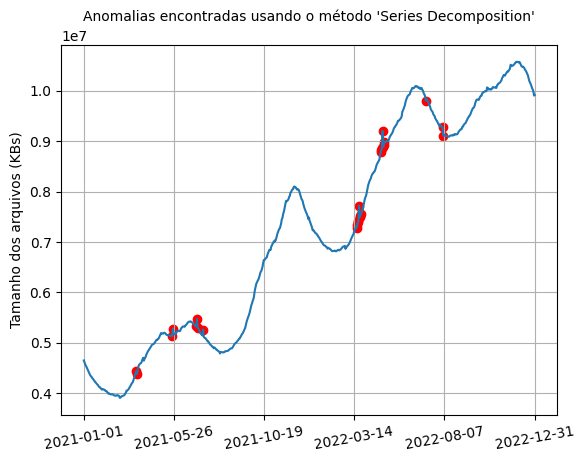

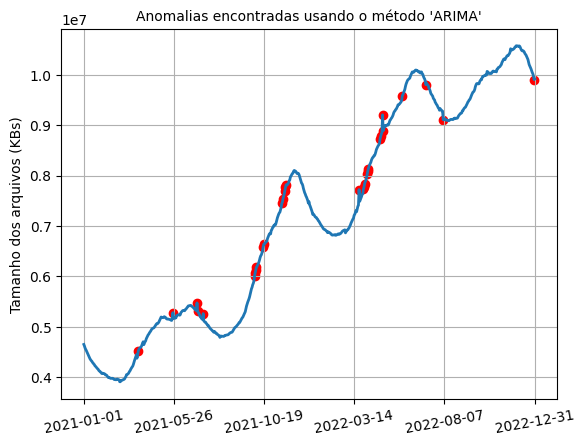

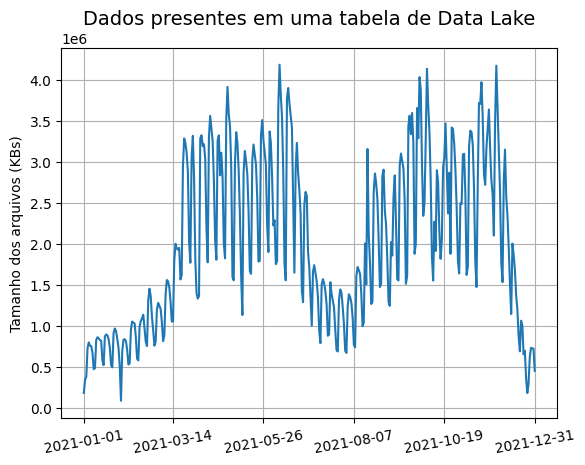

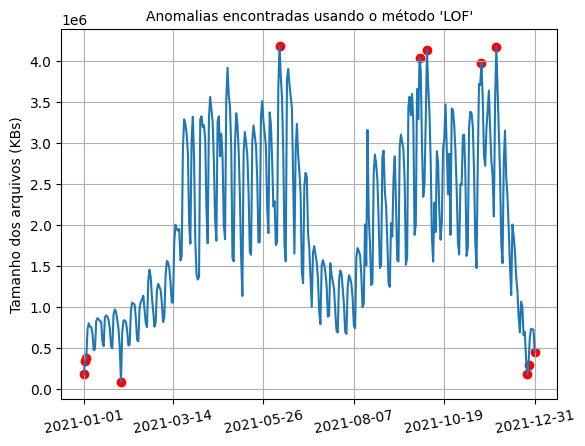

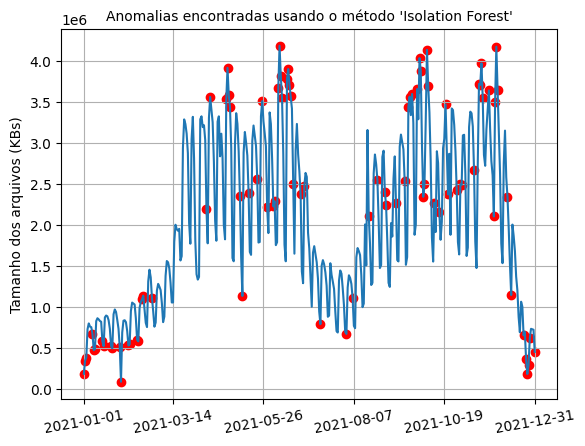

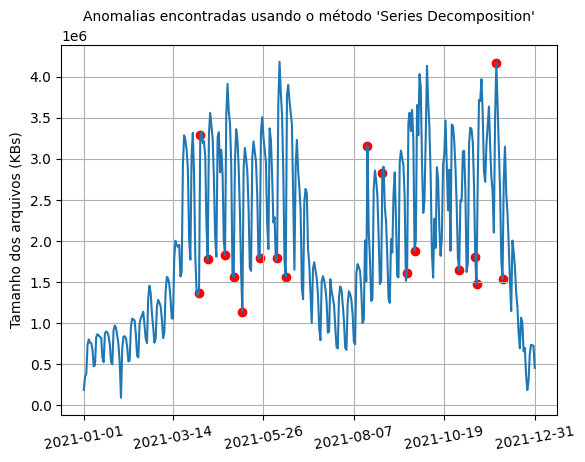

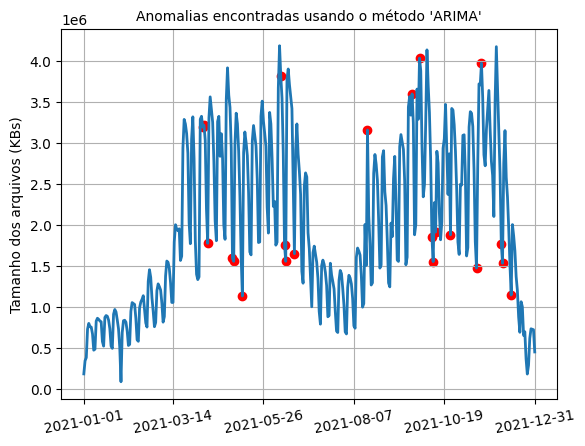

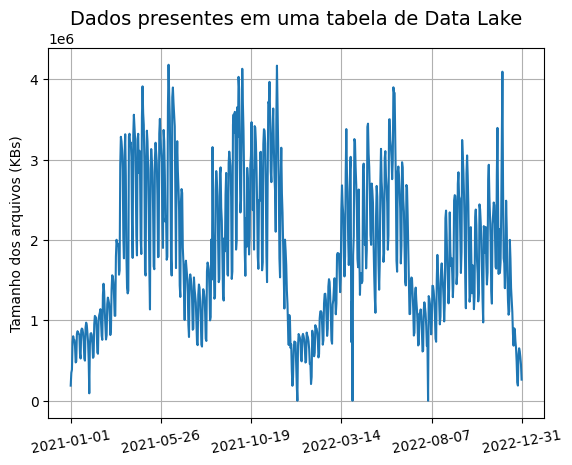

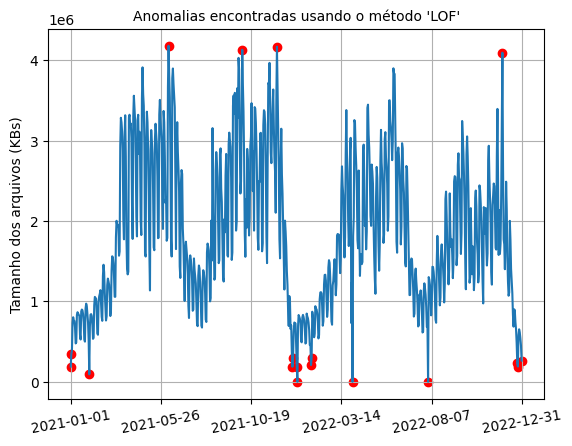

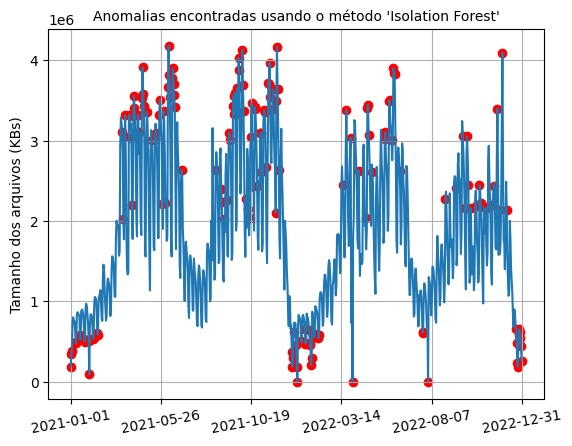

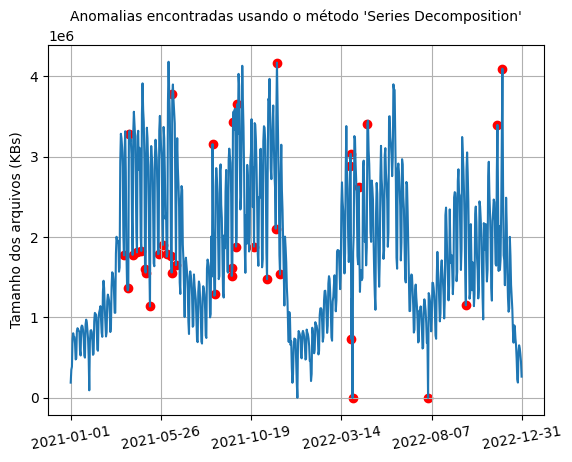

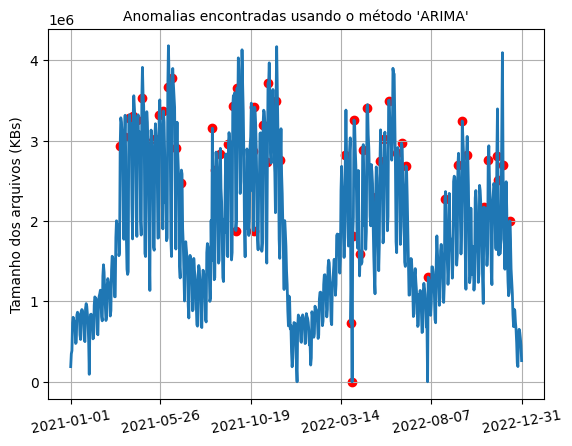

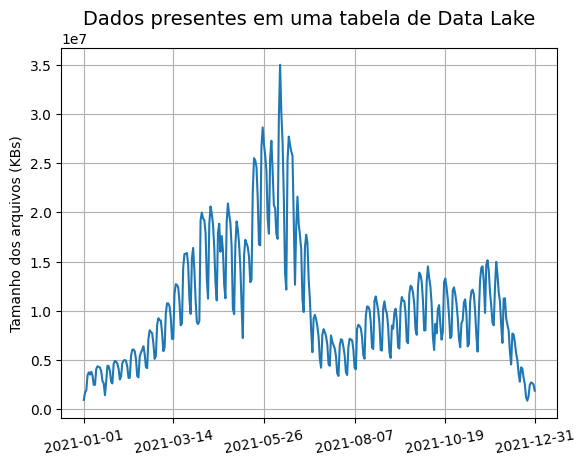

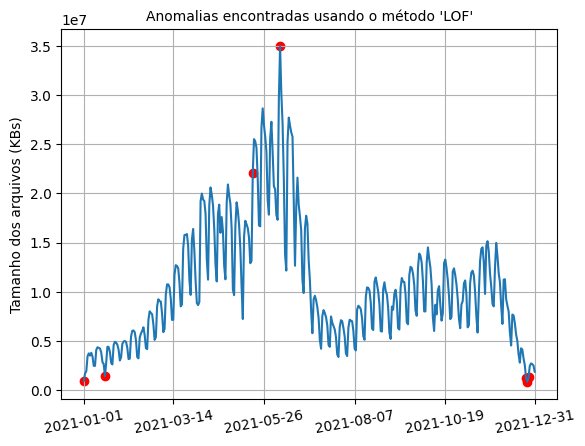

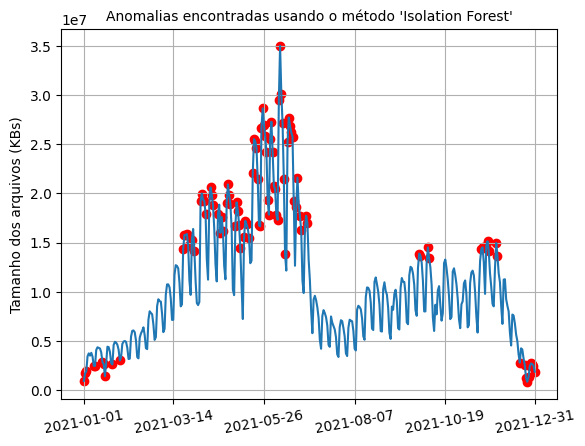

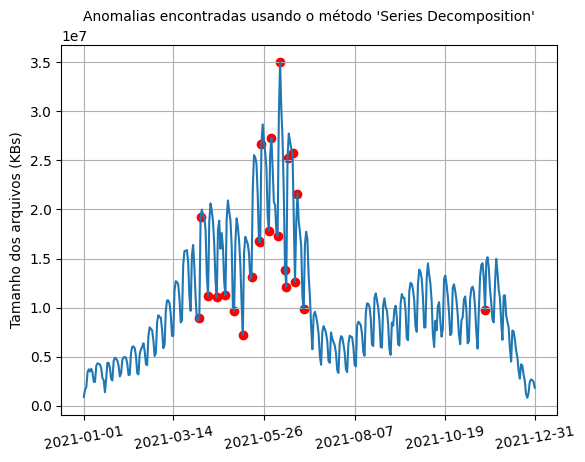

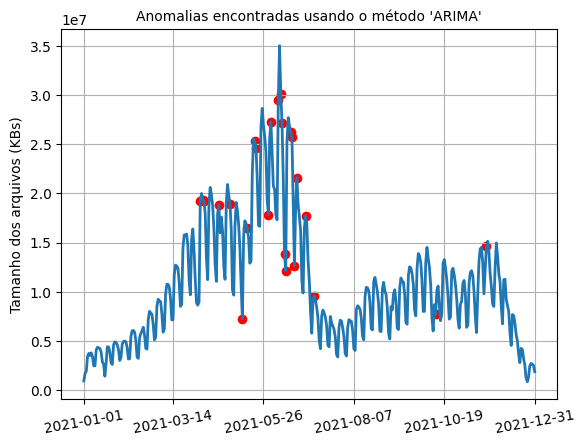

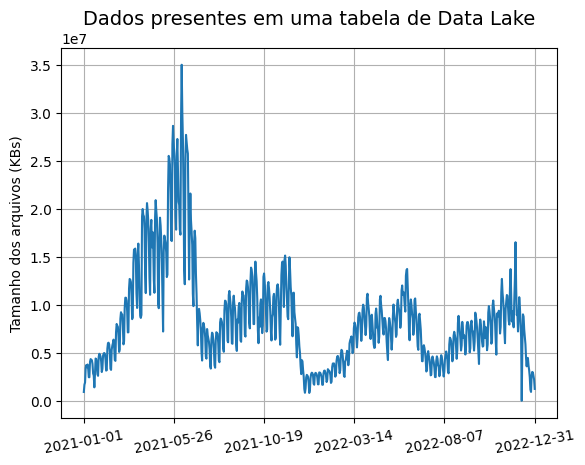

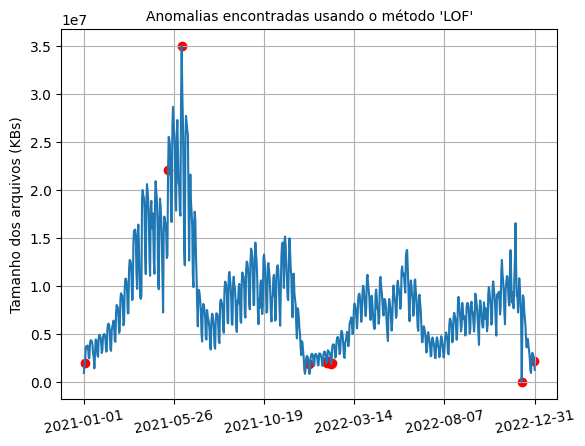

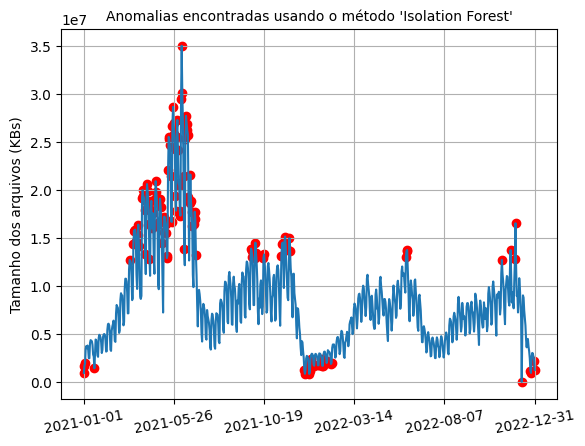

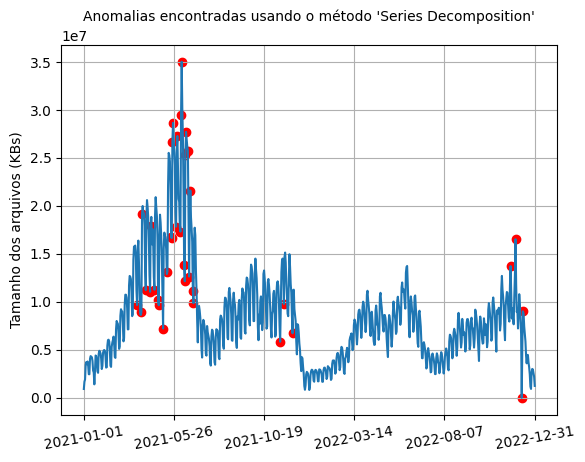

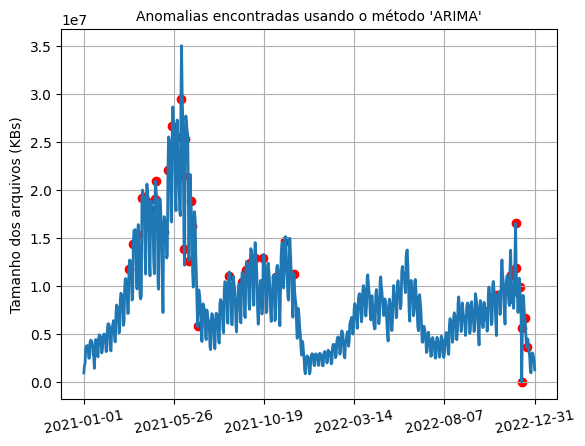

In [35]:
test_n = 0
report_list = []


for test_params in test_list:
    test_choosen = test_n

    run_test(test_choosen)
    report_df = pd.DataFrame(outliers_found)
    report_df.set_index("method", inplace=True)
    report_list.append(report_df)
    outliers_found = []
    test_n = test_n + 1

In [36]:
test = 0
for report in report_list:
    table = test_list[test]["table_for_test"]
    interval = test_list[test]["interval_for_test"][:-1]
    test = test + 1
    print(f"TESTE 0{test}")
    print("\n")
    print(f"table = {table}")
    print(f"interval = {interval}")
    print("\n")
    print(report)
    print("\n")
    print("-----------------------------------------------")
    print("\n")


TESTE 01


table = TAB000001
interval = ('2021-01-01', '2021-06-30')


                      total_outliers percentage
method                                         
LOF                               10      5.52%
Isolation Forest                 103     56.91%
Series Decomposition               9      4.97%
ARIMA                              7      3.87%


-----------------------------------------------


TESTE 02


table = TAB000001
interval = ('2021-01-01', '2022-12-31')


                      total_outliers percentage
method                                         
LOF                               59      8.08%
Isolation Forest                 359     49.18%
Series Decomposition              26      3.56%
ARIMA                             31      4.25%


-----------------------------------------------


TESTE 03


table = TAB000005
interval = ('2021-01-01', '2021-12-31')


                      total_outliers percentage
method                                         
LOF        